# Data Processing
今回は画像を表示させる必要があるので，notebookで作業する

In [1]:
from PIL import Image
import numpy as np

In [2]:
img = Image.open("imori.jpg")

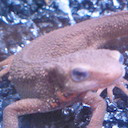

In [3]:
img

## Q.1: Channel Swapping

In [4]:
out = np.array(img)

In [5]:
out.shape

(128, 128, 3)

In [6]:
out = out[:, :, ::-1]

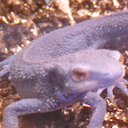

In [7]:
Image.fromarray(out)

## Q.2: Grayscale

In [8]:
out = np.array(img)

In [9]:
out = np.sum(out * [0.2126, 0.7152, 0.0722], axis=2)

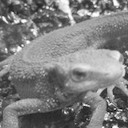

In [10]:
Image.fromarray(out.astype(np.uint8))

In [11]:
gray = out.astype(np.uint8)

## Q.3: Binarization

In [12]:
out = gray.copy()

In [13]:
out[out >= 128] = 255
out[out < 128] = 0

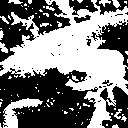

In [14]:
Image.fromarray(out.astype(np.uint8))

## Binarization of Otsu

In [15]:
out = gray.copy()

In [16]:
hist = np.histogram(out, bins=np.arange(256 + 1))[0]

In [17]:
hist.shape

(256,)

In [18]:
for th in range(256):
    n1 = sum(hist[:th])
    n2 = sum(hist[th:])

    if n1 == 0: 
        mu1 = 0
    else: 
        mu1 = sum([i * hist[i] for i in range(0,th)]) / n1   
    if n2 == 0:
        mu2 = 0
    else: 
        mu2 = sum([i * hist[i] for i in range(th, 256)]) / n2

    s = n1 * n2 * (mu1 - mu2) ** 2

    if th == 0 or s > s_max[1]:
        s_max = (th, s)

In [19]:
t = s_max[0]
t

127

In [20]:
out[out >= t] = 255
out[out < t] = 0

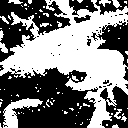

In [21]:
Image.fromarray(out.astype(np.uint8))

## Q.5 HSV Conversion

In [22]:
# めんどいのでいったん放置
def rgb_to_hsv(rgb):
    r, g, b = rgb
    r, g, b = r / 255.0, g / 255.0, b / 255.0
  
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    diff = cmax-cmin
  
    if cmax == cmin: 
        h = 0
    elif cmax == r: 
        h = (60 * ((g - b) / diff) + 360) % 360
    elif cmax == g:
        h = (60 * ((b - r) / diff) + 120) % 360
    elif cmax == b:
        h = (60 * ((r - g) / diff) + 240) % 360
  
    if cmax == 0:
        s = 0
    else:
        s = (diff / cmax) * 100
  
    v = cmax * 100
    return h, s, v

In [23]:
import colorsys

In [24]:
out = np.array(img)

In [25]:
out = out / 255

In [26]:
out = np.apply_along_axis(lambda a: colorsys.rgb_to_hsv(a[0], a[1], a[2]), 2, out)

In [27]:
out[:, :, 0] = (out[:, :, 0] * 360 + 180) % 360 / 360

In [28]:
out = np.apply_along_axis(lambda a: colorsys.hsv_to_rgb(a[0], a[1], a[2]), 2, out)

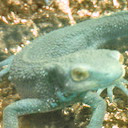

In [29]:
Image.fromarray((out * 255).astype(np.uint8))

## Q.6: Discretization of Color

In [30]:
def quantize(val):
    if 0 <= val and val < 63:
        return 32
    elif 63 <= val and val < 127:
        return 96
    elif 127 <= val and val < 191:
        return 160
    elif 191 <= val and val < 256:
        return 224

In [31]:
out = np.array(img)

In [32]:
vquantize = np.vectorize(quantize, otypes=[np.uint8])

In [33]:
out = vquantize(out)

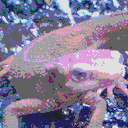

In [34]:
Image.fromarray(out)

## Q.7: Average Pooling

In [35]:
out = np.array(img)

In [36]:
def blockshaped(arr, nrows, ncols):
    h, w, c = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols, c)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols, c))

In [37]:
def unblockshaped(arr, h, w):
    n, nrows, ncols, c = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols, c)
               .swapaxes(1,2)
               .reshape(h, w, c))

In [38]:
blocks = blockshaped(out, 8, 8)

In [39]:
blocks = blocks.mean(axis=(1, 2))

In [40]:
out = blocks.reshape(16, 16, 3)

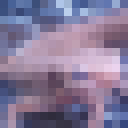

In [41]:
Image.fromarray(out.astype(np.uint8)).resize((128, 128), 0)

## Q.8: Max Pooling

In [42]:
out = np.array(img)

In [43]:
blocks = blockshaped(out, 8, 8)

In [44]:
blocks = blocks.max(axis=(1, 2))

In [45]:
out = blocks.reshape(16, 16, 3)

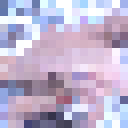

In [46]:
Image.fromarray(out.astype(np.uint8)).resize((128, 128), 0)

## Q.9: Gaussian Filter

In [47]:
noise_img = Image.open("imori_noise.jpg")

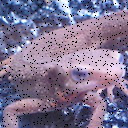

In [48]:
noise_img

In [49]:
ksize_h, ksize_w = 3, 3
sigma=1.3

In [50]:
k = np.zeros([ksize_h, ksize_w])
for iy in range(ksize_h):
    for ix in range(ksize_w):
        k[iy, ix] = 1 / (2 * np.pi * (sigma ** 2)) * np.exp(- ((ix - ksize_w // 2) ** 2 + (iy - ksize_h // 2) ** 2) / (2 * sigma ** 2))
k /= k.sum()

In [51]:
k

array([[0.08941182, 0.12019445, 0.08941182],
       [0.12019445, 0.16157491, 0.12019445],
       [0.08941182, 0.12019445, 0.08941182]])

In [52]:
_img = np.array(noise_img)
_img = np.pad(_img, [(3, 3), (3, 3), (0, 0)], 'edge')

In [53]:
out = np.zeros_like(_img)

In [54]:
for iy in range(out.shape[0] - ksize_h):
    for ix in range(out.shape[1] - ksize_w):
        for ic in range(3):
            out[iy, ix, ic] = np.sum(_img[iy : iy + ksize_h, ix : ix + ksize_w, ic] * k)

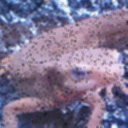

In [55]:
Image.fromarray(out[3:-3, 3:-3, :].astype(np.uint8))

## Q.10: Median Filter

In [56]:
_img = np.array(noise_img)
_img = np.pad(_img, [(3, 3), (3, 3), (0, 0)], 'edge')

In [57]:
out = np.zeros_like(_img)

In [58]:
for iy in range(out.shape[0] - ksize_h):
    for ix in range(out.shape[1] - ksize_w):
        for ic in range(3):
            out[iy, ix, ic] = np.median(_img[iy : iy + ksize_h, ix : ix + ksize_w, ic])

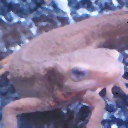

In [59]:
Image.fromarray(out[3:-3, 3:-3, :].astype(np.uint8))